--- Starting Training ---
Epoch 1/30, Average Loss: 0.001840, LR: 0.000500
Epoch 2/30, Average Loss: 0.000781, LR: 0.000500
Epoch 3/30, Average Loss: 0.000420, LR: 0.000500
Epoch 4/30, Average Loss: 0.000521, LR: 0.000500
Epoch 5/30, Average Loss: 0.000587, LR: 0.000250
Epoch 6/30, Average Loss: 0.000289, LR: 0.000250
Epoch 7/30, Average Loss: 0.000204, LR: 0.000250
Epoch 8/30, Average Loss: 0.000237, LR: 0.000250
Epoch 9/30, Average Loss: 0.000267, LR: 0.000250
Epoch 10/30, Average Loss: 0.000300, LR: 0.000125
Epoch 11/30, Average Loss: 0.000171, LR: 0.000125
Epoch 12/30, Average Loss: 0.000116, LR: 0.000125
Epoch 13/30, Average Loss: 0.000103, LR: 0.000125
Epoch 14/30, Average Loss: 0.000115, LR: 0.000125
Epoch 15/30, Average Loss: 0.000097, LR: 0.000063
Epoch 16/30, Average Loss: 0.000107, LR: 0.000063
Epoch 17/30, Average Loss: 0.000085, LR: 0.000063
Epoch 18/30, Average Loss: 0.000094, LR: 0.000063
Epoch 19/30, Average Loss: 0.000077, LR: 0.000063
Epoch 20/30, Average Loss: 0.0000

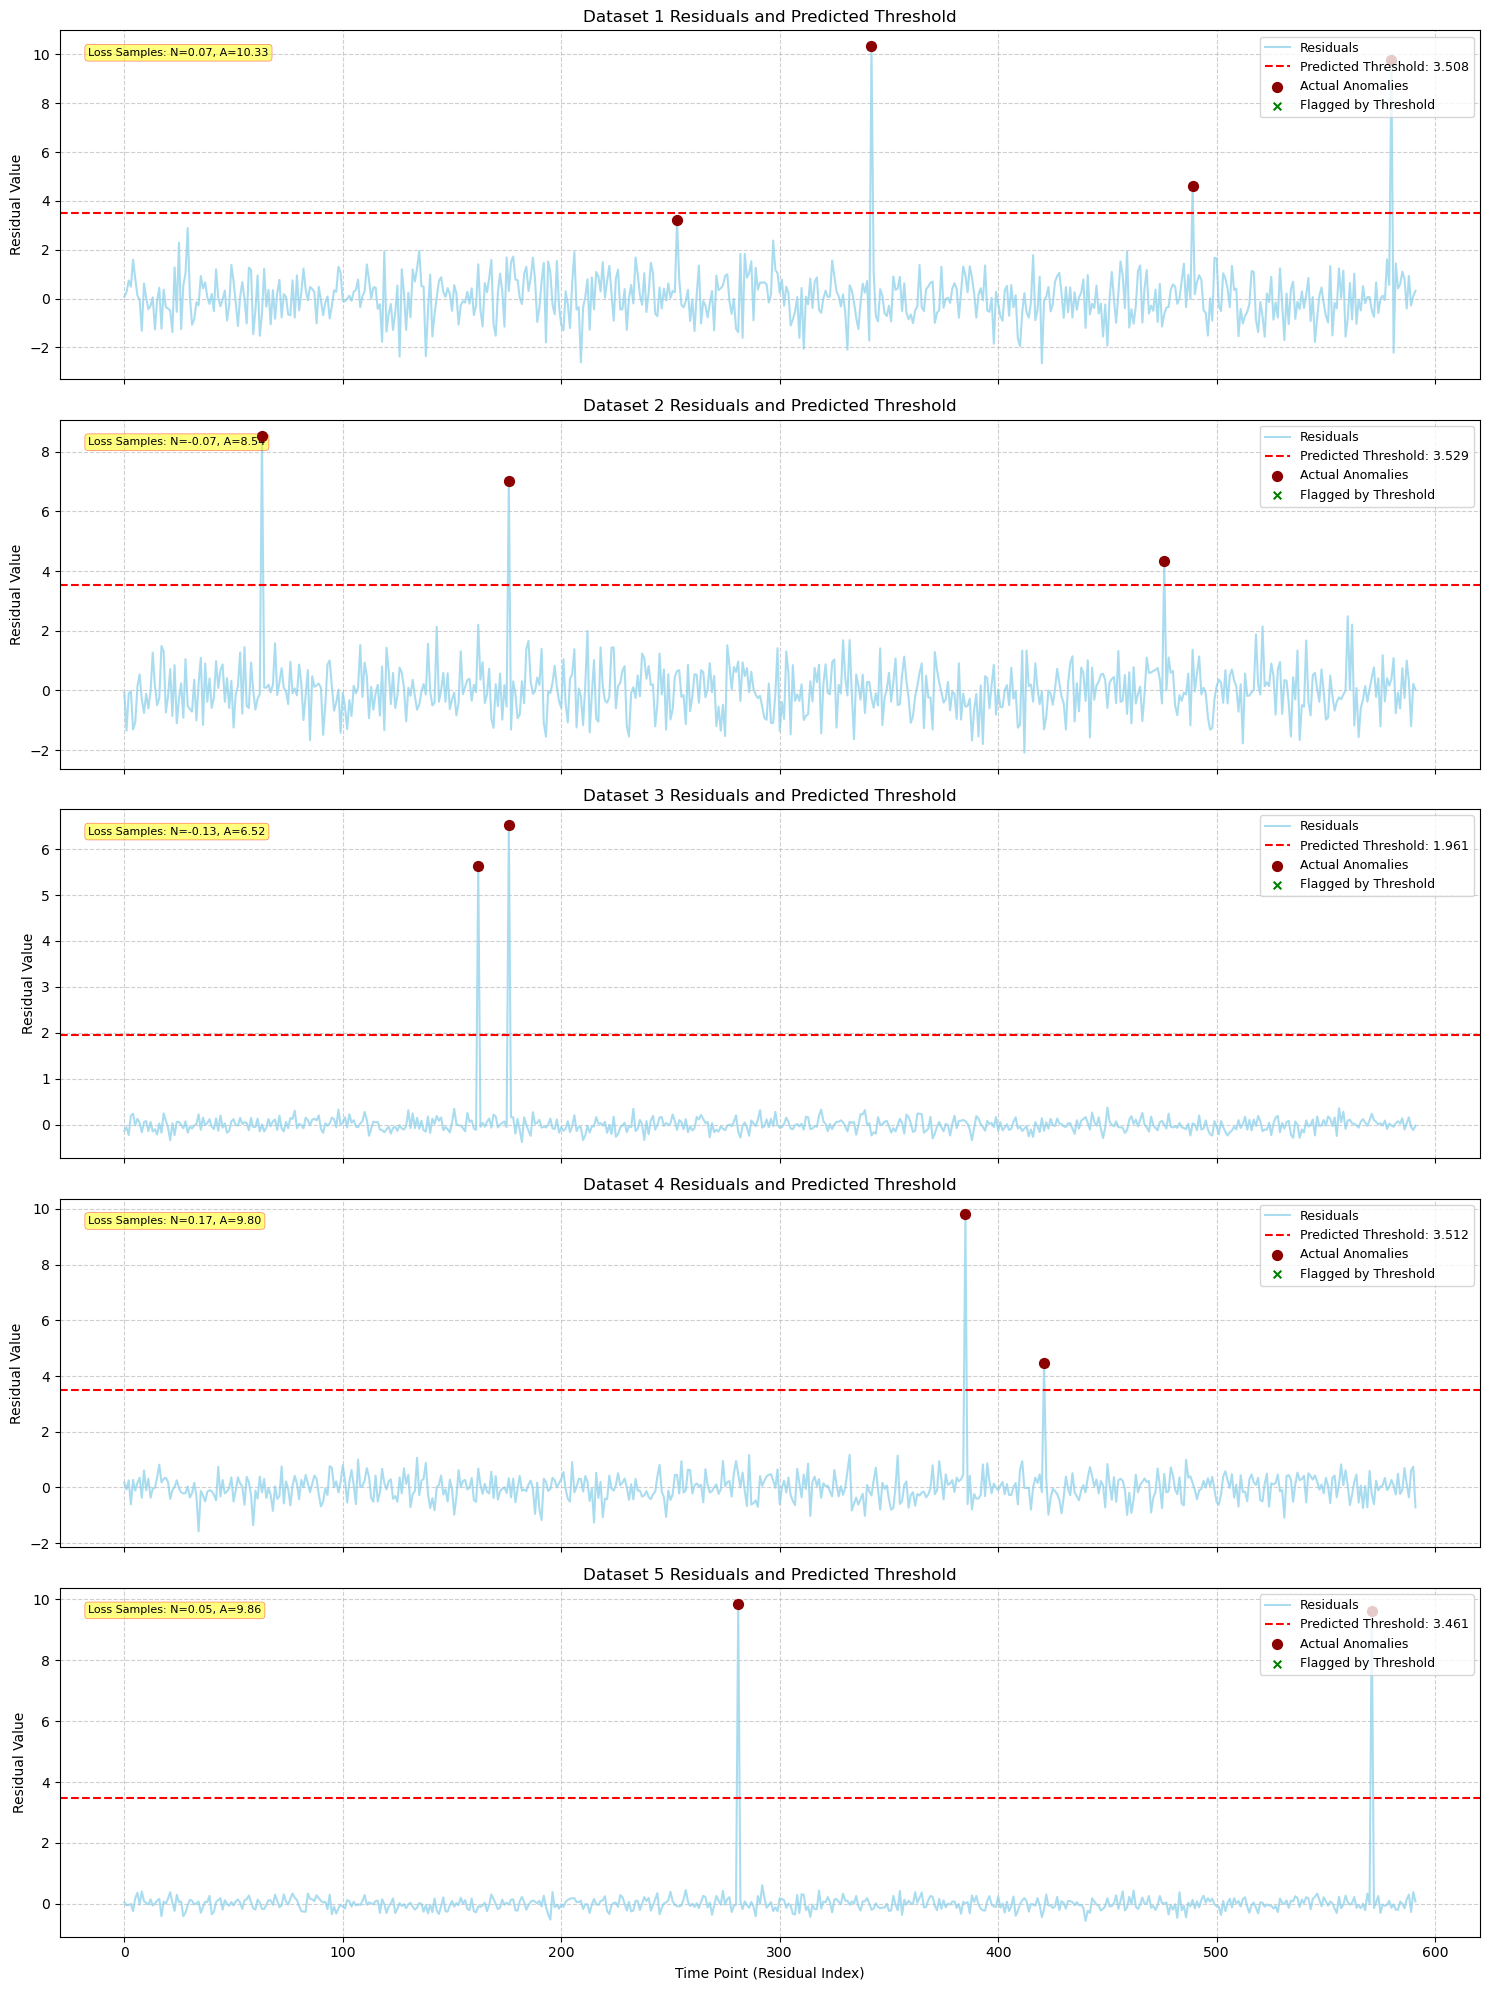

--- Visualization Complete ---


In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class DynamicThresholdModel(nn.Module):
    def __init__(self, input_feat_dim=1, cnn_out_channels=64, d_model=128, nhead=8, d_hid=256, nlayers=3, dropout=0.2):
        super().__init__()
        
        self.conv_extractor = nn.Sequential(
            nn.Conv1d(input_feat_dim, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, cnn_out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(cnn_out_channels),
            nn.ReLU(),
        )
        
        self.d_model = d_model
        self.embedding = nn.Linear(cnn_out_channels, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        self.regressor_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1),
            nn.Softplus() # Softplus為ln(1+e^x)
        )

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        src = src.unsqueeze(1) # (batch_size, sequence_length) -> (batch_size, 1, sequence_length)
        src = self.conv_extractor(src) # (batch_size, cnn_out_channels, new_sequence_length)
        src = src.permute(0, 2, 1) # (batch_size, new_sequence_length, cnn_out_channels)
        
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        
        output = self.transformer_encoder(src) # (batch_size, new_sequence_length, d_model)
        
        pooled_output = output.mean(dim=1) # (batch_size, d_model)
        
        threshold = self.regressor_head(pooled_output) # (batch_size, 1)
        
        return threshold.squeeze(1) # (batch_size,)


class ResidualsDataset(Dataset):
    def __init__(self, num_datasets, points_per_dataset, anomaly_strength_min=2.0, anomaly_strength_max=10.0):
        self.num_datasets = num_datasets
        self.points_per_dataset = points_per_dataset
        self.all_residuals = []
        self.all_anomaly_masks = [] # Store actual anomaly locations
        self.normal_samples = []
        self.anomaly_samples = []

        for _ in range(num_datasets):
            base_noise_std = 0.1 + 0.9 * torch.rand(1) # Vary noise level
            base_noise = torch.randn(points_per_dataset) * base_noise_std
            
            num_anomalies = torch.randint(1, 6, (1,)).item() # 1 to 5 anomalies
            anomaly_indices = torch.randint(0, points_per_dataset, (num_anomalies,)).unique()
            
            anomalies = (torch.rand(len(anomaly_indices)) * (anomaly_strength_max - anomaly_strength_min) + anomaly_strength_min)
            
            current_residuals = base_noise.clone()
            current_anomaly_mask = torch.zeros(points_per_dataset, dtype=torch.bool)
            current_residuals[anomaly_indices] = anomalies
            current_anomaly_mask[anomaly_indices] = True
            
            self.all_residuals.append(current_residuals)
            self.all_anomaly_masks.append(current_anomaly_mask)
            
            # For training: pick one normal and one anomaly sample
            # Ensure there are actual anomalies and normal points
            if current_anomaly_mask.any() and (~current_anomaly_mask).any():
                self.anomaly_samples.append(current_residuals[current_anomaly_mask].max().item()) # Take the max anomaly
                self.normal_samples.append(current_residuals[~current_anomaly_mask][0].item()) # Take first normal
            else: # Fallback if no anomalies or normals are generated (should be rare with new logic)
                self.normal_samples.append(0.1)
                self.anomaly_samples.append(3.0)

    def __len__(self):
        return self.num_datasets

    def __getitem__(self, idx):
        residual_series = self.all_residuals[idx]
        anomaly_mask = self.all_anomaly_masks[idx]
        r_n = self.normal_samples[idx]
        r_a = self.anomaly_samples[idx]
        return residual_series, torch.tensor(r_n, dtype=torch.float32), torch.tensor(r_a, dtype=torch.float32), anomaly_mask

def custom_margin_ranking_loss(threshold, r_n, r_a, margin_n=0.1, margin_a=0.1):
    threshold_clamped = torch.max(threshold, torch.tensor(0.0).to(threshold.device))
    
    loss_n = torch.relu(r_n - threshold_clamped + margin_n)
    loss_a = torch.relu(threshold_clamped - r_a + margin_a)
    total_loss = (loss_n + loss_a).mean()
    return total_loss

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_residuals_per_set = 10080 // 17
    
    print("--- Starting Training ---")
    train_dataset = ResidualsDataset(num_datasets=10000, points_per_dataset=num_residuals_per_set)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

    model = DynamicThresholdModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    epochs = 30
    model.train()
    for epoch in range(epochs):
        total_epoch_loss = 0
        for batch_idx, (residual_series, r_n, r_a, _) in enumerate(train_dataloader):
            residual_series = residual_series.to(device)
            r_n = r_n.to(device)
            r_a = r_a.to(device)

            optimizer.zero_grad()
            
            predicted_threshold = model(residual_series)
            loss = custom_margin_ranking_loss(predicted_threshold, r_n, r_a)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # 做梯度裁減避免梯度爆炸
            optimizer.step()
            
            total_epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = total_epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    print("--- Training Finished ---")

    # --- Testing and Visualization ---
    print("\n--- Starting Testing and Visualization ---")
    model.eval()
    num_test_visualizations = 5 # Number of datasets to visualize

    test_dataset_vis = ResidualsDataset(num_datasets=num_test_visualizations, points_per_dataset=num_residuals_per_set, 
                                        anomaly_strength_min=3.0, anomaly_strength_max=12.0) # Stronger anomalies for vis

    with torch.no_grad():
        fig, axes = plt.subplots(num_test_visualizations, 1, figsize=(15, 4 * num_test_visualizations), sharex=True)
        if num_test_visualizations == 1:
            axes = [axes]

        for i in range(num_test_visualizations):
            series, r_n_sample, r_a_sample, anomaly_mask = test_dataset_vis[i]
            series_batch = series.unsqueeze(0).to(device)
            
            inferred_threshold = model(series_batch).item()

            ax = axes[i]
            x_indices = np.arange(len(series))
            
            ax.plot(x_indices, series.cpu().numpy(), label='Residuals', color='skyblue', alpha=0.7)
            ax.axhline(y=inferred_threshold, color='red', linestyle='--', label=f'Predicted Threshold: {inferred_threshold:.3f}')

            # ----- HL ----- #
            anomaly_indices = torch.where(anomaly_mask)[0].cpu().numpy()
            if len(anomaly_indices) > 0:
                ax.scatter(anomaly_indices, series[anomaly_indices].cpu().numpy(), 
                           color='darkred', marker='o', s=50, zorder=5, label='Actual Anomalies')

            flagged_indices = torch.where(series > inferred_threshold)[0].cpu().numpy()
            if len(flagged_indices) > 0:
                ax.scatter(flagged_indices, series[flagged_indices].cpu().numpy(), 
                           color='green', marker='x', s=30, zorder=4, label='Flagged by Threshold')
            
            ax.set_title(f'Dataset {i+1} Residuals and Predicted Threshold', fontsize=12)
            ax.set_ylabel('Residual Value', fontsize=10)
            ax.legend(fontsize=9, loc='upper right')
            ax.grid(True, linestyle='--', alpha=0.6)
            
            ax.text(0.02, 0.95, f'Loss Samples: N={r_n_sample.item():.2f}, A={r_a_sample.item():.2f}', 
                    transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="red", lw=0.5, alpha=0.5))


        plt.xlabel('Time Point (Residual Index)', fontsize=10)
        plt.tight_layout()
        plt.show()

    print("--- Visualization Complete ---")